## **손글씨 숫자 이미지 분류 - MNIST를 활용한 DNN 모델 만들기_by Tensorflow**


## 1.라이브러리 가져오기

In [4]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2.MNIST 데이터셋 가져오고 살펴보기

- Keras 에는 MNIST 데이터셋이 내장되어 있어서 tf.keras.datasets.mnist.load_data() 메소드로 로딩을 할 수 있습니다. Training set에 6만개, Test set에 1만개의 손글씨 숫자 데이터와 정답지 라벨 데이터가 있습니다.

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('shape of x_train:', x_train.shape)
print('shape of y_train:', y_train.shape)
print('shape of x_test:', x_test.shape)
print('shape of y_test:', y_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
shape of x_train: (60000, 28, 28)
shape of y_train: (60000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)


- Training set의 0번째 이미지 데이터 배열(28 by 28 array)과 정답지 라벨 ('5'), 그리고 matplotlib 으로 시각화


In [5]:
print(x_train[0])
print(y_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

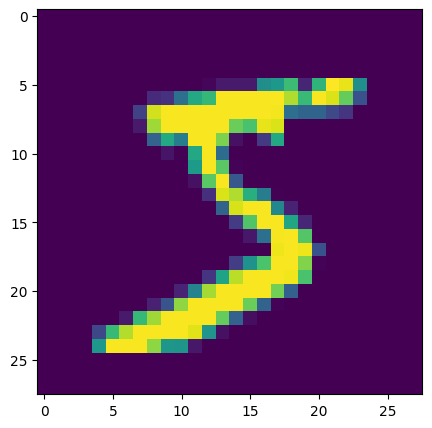

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5)
plt.imshow(x_train[0])
plt.show()

## 3.데이터 전처리하기


    - 형태 맞추기     
Deep Neural Network 모델의 input으로 넣기 위해 (28 by 28) 2차원 배열 (2D array) 이미지를 (28 * 28 = 784) 의 옆으로 길게 펼친 데이터 형태로 변형(Reshape) 합니다(Flatten() 메소드를 사용해도 됨).
    - 정규화하기      
    신경망은 입력 데이터의 스케일에 민감하기 때문에, 이 값을 0과 1 사이의 범위로 조정하는 정규화 과정(0~255 사이의 값을 0~1 사이의 실수 값으로 변환) 필요

In [ ]:
# reshape and normalization
x_train = x_train.reshape((60000, 28 * 28)) / 255.0
x_test = x_test.reshape((10000, 28 * 28)) / 255.0

## 4.모델 구현하기
- Keras의 핵심 데이터 구조로 모델(Models)과 층(Layers)이 있습니다.
    - 모델 구축 두가지 방법
        - (a) 순차적으로 층을 쌓아가는 Sequential model 과,
        - (b) 복잡한 구조의 모델을 만들 때 사용하는 Keras functional API
- 이미지 데이터 분류는 CNN (Convolutional Neural Network) 을 사용하면 효과적이나 이 예제에서는 간단하게 Sequential model 을 사용하여 모델 구성합니다.
 - (1)에서 전처리한 Input 이미지 데이터를 받아서, 1개의 완전히 연결된 은닉층 (Fully Connected Hidden Layer) 을 쌓고,
 - 10개의 classes 별 확률을 반환하는 FC(Fully Connected) Output Layer 를 쌓아서 만든 DNN(Deep Neural Network) 모델을 만들어보겠습니다.(Functional API 는 PyTorch 와 유사함)  
 - add() 메소드를 사용하면 마치 레고 블록을 쌓듯이 차곡차곡 순서대로 원하는 층을 쌓아서 딥러닝 모델을 설계할 수 있습니다.

- (Dense, CNN, RNN, Embedding 등 모두 가능). Dense() 층의 units 매개변수에는 층별 노드 개수를 지정해주며, 활성화 함수는 activation 매개변수에서 지정해줍니다. 은닉층에서는 'Relu' 활성화함수를, Output 층에는 10개 classes에 대한 확률을 반환하므로 'softmax' 활성화함수를 사용하였습니다.


### 1)모델 구성하기

In [ ]:
# Sequential model
# model = tf.keras.models.Sequential()
# # Stacking layers
# input_shape = (28*28,)
# model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape))
# model.add(tf.keras.layers.Dense(10, activation='softmax'))

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28*28,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

- 층을 쌓아서 만든 DNN (Deep Neural Network) 모델이 어떻게 생겼는지 summary() 함수로 출력해보고, tf.keras.utils.plot_model() 메소드로 시각화


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

### 2)모델 컴파일 (Compiling the model)하기
-  기계가 이 모델을 이해할 수 있고 학습 절차를 설정할 수 있도록 컴파일(Compile) 해줍니다. compile() 메소드에는 딥러닝 학습 시 사용하는 (a) 오차 역전파 경사하강법 시 최적화 알고리즘(optimizer), (b) 손실함수(loss function), 그리고 (c) 성과평가 지표(metrics) 를 설정해줍니다.


In [ ]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(
#     optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
#     loss=keras.losses.sparse_categorical_crossentropy)

 - input data의 다수 클래스에 대한 정답 레이블(ground-truth labels)을 바로 사용하여 손실함수를 계산할 때는 loss='sparse_categorical_crossentropy' 을 사용
 - One-hot encoding 형태로 정답 레이블이 되어있다면 loss='categorical_crossentropy' 를 사용

###  3)모델 학습 (Training the model)

- 데이터 준비와 모델 구축, 그리고 모델 컴파일이 끝났으므로 이제 6만개의 훈련 데이터셋(Training set) 중에서 80% (4.8만개 데이터) 는 모델 학습(fitting)에, 20%(1.2만개 데이터)는 검증(validation)용으로 사용하여 DNN 모델을 학습해보겠습니다. (참고로, 1만개의 Test set은 모델 학습에서는 사용하지 않으며, 최종 모델에 대해서 제일 마지막에 모델 성능 평가를 위해서만 사용합니다.)
- epochs = 5 는 전체 데이터를 5번 반복(iteration)해서 사용해서 학습한다는 의미입니다.
- verbose = 1 은 모델 학습 진행상황 막대를 출력하라는 의미입니다. ('1' 이 default이므로 생략 가능)(0 = silent, 1 = progress bar, 2 = one line per epoch)
- validation_split=0.2 는 검증용 데이터셋을 별도로 만들어놓지 않았을 때 학습용 데이터셋에서 지정한 비율(예: 20%) 만큼을 분할하여 (hyperparameter tuning을 위한) 검증용 데이터셋으로 이용하라는 의미입니다.
- batch_size=32 는 한번에 데이터 32개씩 batch로 가져다가 학습에 사용하라는 의미입니다.
- 학습이 진행될수록 (즉, epochs 이 증가할 수록) 검증용 데이터셋에 대한 손실 값(loss value)은 낮아지고 정확도(accuracy)는 올라가고 있네요.


In [ ]:
model.fit(x_train, y_train,
          epochs=10,
          verbose=1,
          validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7036 - loss: 1.1220 - val_accuracy: 0.8999 - val_loss: 0.3779
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8962 - loss: 0.3834 - val_accuracy: 0.9150 - val_loss: 0.3075
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9107 - loss: 0.3183 - val_accuracy: 0.9239 - val_loss: 0.2760
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9205 - loss: 0.2790 - val_accuracy: 0.9296 - val_loss: 0.2537
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9286 - loss: 0.2587 - val_accuracy: 0.9338 - val_loss: 0.2368
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9313 - loss: 0.2424 - val_accuracy: 0.9385 - val_loss: 0.2231
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9371 - loss: 0.2237 - val_accuracy: 0.9423 - val_loss: 0.2115
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9391 - loss: 0.2159 - 

### 4)모델 평가 (Evaluating the model)
= evaluate() 메소드를 사용하여 모델의 손실 값(Loss value) 과 컴파일 단계에서 추가로 설정해준 성능지표 값 (Metrics values) 을 Test set 에 대하여 평가할 수 있습니다. (다시 한번 강조하자면, Test set은 위의 (4)번 학습 단계에서 절대로 사용되어서는 안됩니다!)
- Test set에 대한 cross entropy 손실값은 0.185, 정확도(accuracy)는 94.8% 가 나왔네요. (CNN 모델을 이용하고 hyperparameter tuning을 하면 99%까지 정확도를 올릴 수 있습니다.)
`

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

313/313 - 1s - 3ms/step - accuracy: 0.9497 - loss: 0.1804
test_loss: 0.1804197132587433
test_accuracy: 0.9496999979019165


### 5)모델 예측하기 (Prediction for new data)
위에서 학습한 DNN 모델을 사용해서 MNIST 이미지 데이터에 대해서 predict() 메소드를 사용하여 예측을 해보겠습니다. (별도의 새로운 데이터가 없으므로 test set 데이터를 사용함)굵은 텍스트

In [ ]:
preds = model.predict(x_test)
# returns an array of probability per classes
preds[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([4.5021130e-05, 3.8166014e-08, 3.6046369e-04, 2.5160944e-03,
       3.9589960e-07, 4.7842412e-05, 1.3842259e-08, 9.9665952e-01,
       2.5056717e-05, 3.4555409e-04], dtype=float32)

In [ ]:
# position of max probability
np.argmax(preds[0])

7

In [ ]:
y_test[0]

7

In [ ]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값.
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자.
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
model.predict() 결과 :  [4.5021130e-05 3.8166014e-08 3.6046369e-04 2.5160944e-03 3.9589960e-07
 4.7842412e-05 1.3842259e-08 9.9665952e-01 2.5056717e-05 3.4555409e-04]
model이 추론한 가장 가능성이 높은 결과 :  7
실제 데이터의 라벨 :  7


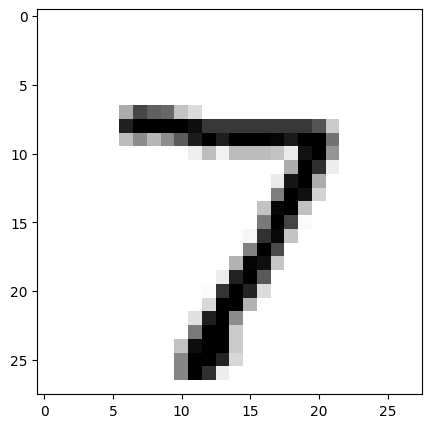

In [ ]:
plt.imshow(x_test[idx].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

### 6)모델 저장, 불러오기 (Saving and Loading the model)
- 딥러닝 모델의 성과 평가 결과 기준치를 충족하여 현장 적용이 가능한 경우라면 모델의 요소와 학습된 가중치 정보를 파일 형태로 저장하고, 배포, 로딩해서 (재)활용할 수 있습니다.

In [ ]:
# Save the entire model to a HDF5 file.
#model.save('mnist_dnn_model.h5')
model.save('mnist_dnn_model.keras')


- 저장된 'mnist_dnn_model.h5' 모델/가중치 파일을 'new_model' 이름으로 불러오기

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('mnist_dnn_model.h5')
new_model = tf.keras.models.load_model('mnist_dnn_model.keras')
new_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,542 (795.09 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,772 (397.55 KB)

## **2. 의류 이미지 분류 - Fashion MNIST를 활용한 DNN 모델 만들기**

이 튜토리얼에서는 운동화나 셔츠 같은 옷 이미지를 분류하는 신경망 모델을 훈련합니다. 상세 내용을 모두 이해하지 못해도 괜찮습니다. 여기서는 완전한 텐서플로(TensorFlow) 프로그램을 빠르게 살펴 보겠습니다. 자세한 내용은 앞으로 배우면서 더 설명합니다.

여기에서는 텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 [tf.keras](https://www.tensorflow.org/guide/keras)를 사용합니다.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.17.0


## 1) 패션 MNIST 데이터셋 가져오기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

<table>
  <tr><td>     <img src="https://tensorflow.org/images/fashion-mnist-sprite.png" alt="Fashion MNIST sprite" width="600">   </td></tr>
  <tr><td align="center">     <b>그림 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br>{nbsp}   </td></tr>
</table>

패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.

패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.

여기에서 60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가합니다. TensorFlow에서 직접 Fashion MNIST에 액세스할 수 있습니다. TensorFlow에서 직접 [Fashion MNIST 데이터](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)를 가져오고 로드합니다.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
mnist = tf.keras.datasets.mnist

...     # ... 코드 입력

load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

- `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 *훈련 세트*입니다.
- `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 *테스트 세트*입니다.

이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. *레이블*(label)은 0에서 9까지의 정수 배열입니다. 이 값은 이미지에 있는 옷의 *클래스*(class)를 나타냅니다:

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 *클래스 이름*이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장합니다:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 2) 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [ ]:
train_images.shape

비슷하게 훈련 세트에는 60,000개의 레이블이 있습니다:

In [ ]:
len(train_labels)

각 레이블은 0과 9사이의 정수입니다:

In [ ]:
train_labels

테스트 세트에는 10,000개의 이미지가 있습니다. 이 이미지도 28x28 픽셀로 표현됩니다:

In [ ]:
test_images.shape

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있습니다:

In [ ]:
len(test_labels)

## 3) 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요합니다:

In [ ]:
train_images = ...     # ... 코드 입력

test_images = ...     # ... 코드 입력

*훈련 세트*에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 4) 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.

### 4-1)층 설정

신경망의 기본 빌딩 블록은 [*레이어*](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 입니다. 레이어는 레이어에 공급된 데이터로부터 표현을 추출합니다. 이러한 표현은 당면한 문제에 의미가 있어야 합니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [ ]:
# 1개의 은닉층 - 노드 128 개 인 모델을 구성하세요
model =  ...    # ... 코드 입력







이 네트워크의 첫 번째 층인 `tf.keras.layers.Flatten`은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 합니다.

픽셀을 펼친 후에는 두 개의 `tf.keras.layers.Dense` 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 `Dense` 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 *소프트맥스*(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

### 4-2)모델 컴파일

모델을 훈련할 준비가 되기 전에 몇 가지 설정이 더 필요합니다. 다음은 모델의 [*컴파일*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) 단계에서 추가됩니다.

- [*손실 함수*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) - 훈련 중 모델이 얼마나 정확한지 측정합니다. 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 합니다.
- [*옵티마이저*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식입니다.
- [*메트릭*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — 훈련 및 테스트 단계를 모니터링하는 데 사용됩니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도*를 사용합니다.

In [ ]:
# 모델 컴파일하기 : 손실함수 - 'sparse_categorical_crossentropy', 옵티마이저 : 'adam' , metricsc : 'accuracy'

...    # ... 코드 입력

## 5) 모델 훈련

신경망 모델을 훈련하려면 다음 단계가 필요합니다.

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 `train_images`와 `train_labels` 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 `test_images` 배열입니다. 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인합니다.
4. 예측이 `test_labels` 배열의 레이블과 일치하는지 확인합니다.


- 모델 학습

훈련을 시작하려면 [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) 메서드를 호출합니다. 모델을 훈련 데이터에 "맞추기(fit)" 때문에 이렇게 불립니다.

In [ ]:
# 모델 학습하기  - epochs = 10
history = ...     # ... 코드 입력

## 6) 모델 훈련 후 분석

In [ ]:
# 모델 학습과정 그래프로 나타내기

...     # ... 코드 입력

plt.show()

모델이 훈련되면서 손실과 정확도 지표가 출력됩니다. 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성합니다.

## 7) 모델 평가

모델이 테스트 데이터세트에서 작동하는 방식을 비교합니다. - evaluate() 사용

In [ ]:
test_loss, test_acc = ...     # ... 코드 입력

print('\nTest accuracy:', test_acc)

테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 *과대적합*(overfitting) 때문입니다. 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

- [과대적합 시연](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
- [과대적합을 방지하기 위한 전략](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

## 8) 예측하기

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있습니다. 모델의 선형 출력, [로짓](https://developers.google.com/machine-learning/glossary#logits). 소프트맥스 레이어를 연결하여 로짓을 해석하기 쉬운 확률로 변환합니다.

In [ ]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했습니다. 첫 번째 예측을 확인해 보죠:

In [ ]:
predictions[0]

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [ ]:
np.argmax(predictions[0])

모델은 이 이미지가 앵클 부츠(`class_name[9]`)라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [ ]:
test_labels[0]

10개 클래스에 대한 예측을 모두 그래프로 표현해 보겠습니다:

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

## 9) 예측 확인

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있습니다.

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 10) 훈련된 모델 사용하기

마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듭니다.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

`tf.keras` 모델은 한 번에 샘플의 묶음 또는 *배치*(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 합니다:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

이제 이 이미지의 예측을 만듭니다:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict`는 데이터 배치의 각 이미지에 대해 하나의 목록씩 목록의 목록을 반환합니다. 배치에서 (유일한) 이미지에 대한 예측을 가져옵니다.

In [ ]:
np.argmax(predictions_single[0])

예상과 같이 모델이 레이블을 예측합니다.